# 🌍 Cross-Language Evaluation with Multilingual BERT

## Introduction

In this session, we explore how **multilingual language models** like `distilbert-base-multilingual-cased` perform across different **natural languages** in a **sentiment classification task**.

### 📚 What We'll Use

- **Model**: [`distilbert-base-multilingual-cased`](https://https://huggingface.co/distilbert/distilbert-base-multilingual-cased)  
  Pretrained on 104 languages with shared vocabulary and weights.
  
- **Dataset**: [`multilingual-sentiments`](https://huggingface.co/datasets/tyqiangz/multilingual-sentiments)  
  Contains labeled sentiment examples in 6 languages:
  - 🇺🇸 English
  - 🇫🇷 French
  - 🇯🇵 Japanese
  - 🇮🇳 Hindi
  - 🇲🇾 Malay
  - 🇸🇦 Arabic


### 🧪 What We'll Do

| Step | Description |
|------|-------------|
| **1. Load & Explore** | Load the dataset and inspect sentiment distribution per language. |
| **2. Balanced Fine-Tuning** | Train `bert-base-multilingual-cased` using an equal number of samples per language. |
| **3. Learning Curves** | Track accuracy per language over time to compare learning speed. |
| **4. Zero-Shot Transfer** | Train on one language, test on others to evaluate cross-lingual generalization. |


### 🎯 Key Questions

- How well does multilingual BERT generalize across languages?
- Do all languages learn at the same rate with equal data?
- Can training on one language improve performance in others?

---

## 📚 Loading and Exploring the Dataset

Let’s begin by loading and exploring the dataset.

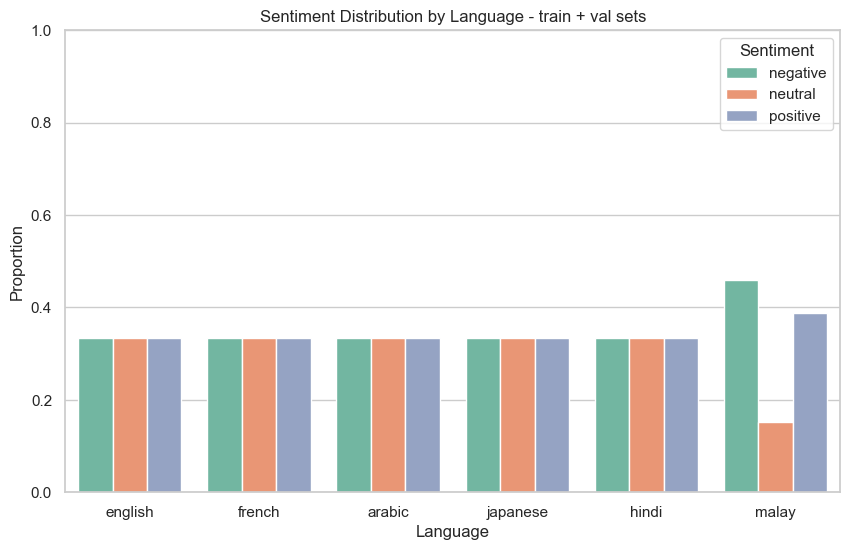

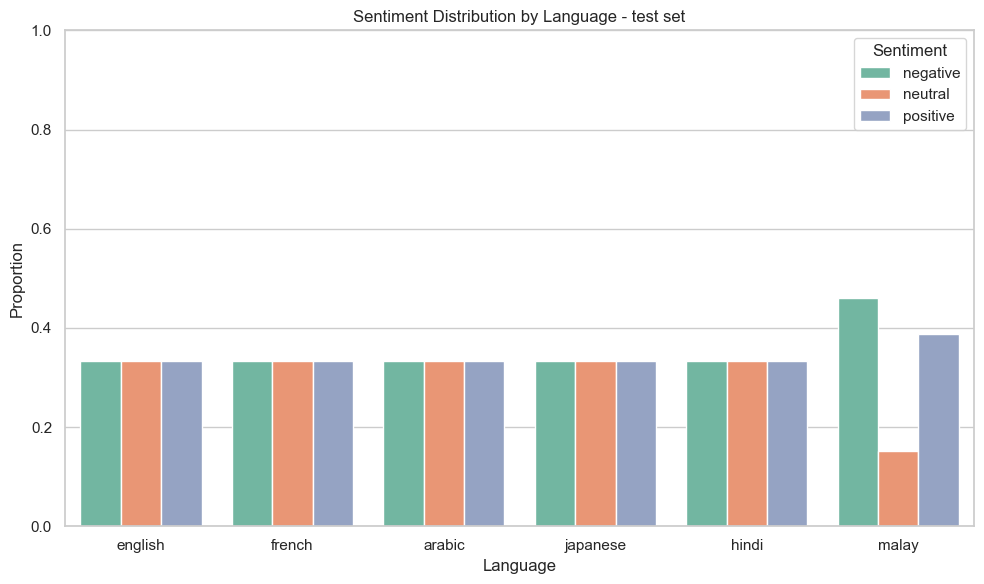

In [1]:
from datasets import load_dataset
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load multilingual sentiment dataset
dataset = load_dataset("tyqiangz/multilingual-sentiments", "all")
train = dataset['train'].to_pandas()
test = dataset['test'].to_pandas()
val = dataset['validation'].to_pandas()

# We'll combine train and validation sets for now (as instructed)
lang_stats, lang_test_stats = {}, {}
langs = ['english', 'french', 'arabic', 'japanese', 'hindi', 'malay']

# Combine splits and compute statistics
for lang in langs:
    df_train = train.loc[train.loc[:, 'language'] == lang, :].copy()
    df_val = val.loc[val.loc[:, 'language'] == lang, :].copy()
    df_combined = pd.concat([df_train, df_val])
    df_combined['language'] = lang
    
    # Store descriptive stats
    counts = df_combined['label'].value_counts(normalize=True).sort_index()
    lang_stats[lang] = {
        'total_samples': len(df_combined),
        'positive': counts.get(2, 0),
        'neutral': counts.get(1, 0),
        'negative': counts.get(0, 0)
    }

    counts = test.loc[test.loc[:, 'language'] == lang, :].copy()['label'].value_counts(normalize=True).sort_index()
    lang_test_stats[lang] = {
        'total_samples': len(test.loc[test.loc[:, 'language'] == lang, :]),
        'positive': counts.get(2, 0),
        'neutral': counts.get(1, 0),
        'negative': counts.get(0, 0)
    }

plot_data, plot_test_data = [], []

for lang, stats in lang_stats.items():
    for sentiment, value in [('negative', stats['negative']),
                              ('neutral', stats['neutral']),
                              ('positive', stats['positive'])]:
        plot_data.append({
            'language': lang,
            'sentiment': sentiment,
            'proportion': value
        })

for lang, stats in lang_test_stats.items():
    for sentiment, value in [('negative', stats['negative']),
                              ('neutral', stats['neutral']),
                              ('positive', stats['positive'])]:
        plot_test_data.append({
            'language': lang,
            'sentiment': sentiment,
            'proportion': value
        })

plot_df = pd.DataFrame(plot_data)
plot_test_df = pd.DataFrame(plot_test_data)

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.barplot(
    x='language',
    y='proportion',
    hue='sentiment',
    data=plot_df,
    palette='Set2'
)

plt.title("Sentiment Distribution by Language - train + val sets")
plt.ylabel("Proportion")
plt.xlabel("Language")
plt.ylim(0, 1)
plt.legend(title="Sentiment", loc='upper right')

plt.figure(figsize=(10, 6))
sns.barplot(
    x='language',
    y='proportion',
    hue='sentiment',
    data=plot_test_df,
    palette='Set2'
)

plt.title("Sentiment Distribution by Language - test set")
plt.ylabel("Proportion")
plt.xlabel("Language")
plt.ylim(0, 1)
plt.legend(title="Sentiment", loc='upper right')
plt.tight_layout()
plt.show()


### 📊 Observations on Sentiment Distribution

From the visual analysis of sentiment proportions across languages:

1. **Balanced Distributions**  
   - For **English**, **French**, **Arabic**, **Japanese**, and **Hindi**, sentiment labels are nearly perfectly balanced:
     - ~33% each for **positive**, **neutral**, and **negative**.

2. **Malay Difference**  
   - **Malay** shows a clear imbalance:
     - **Negative** sentiment dominates (~45–50%),
     - **Neutral** sentiment is underrepresented (around 15%).

### 🧪 Implication for Training

To ensure a **fair comparison across languages**, we will:
- **Sample an equal number of training examples per language**, avoiding imbalance bias,
- Track **performance over increasing dataset sizes** to compare:
  - **Learning efficiency** (how quickly accuracy improves),
  - **Language difficulty** for the model.

Let’s now fine-tune `disitlbert-base-multilingual-cased` on multiple languages and monitor the learning curves.

---

## 🔧 Fine-Tuning Multilingual BERT on Balanced Data

To fairly evaluate multilingual performance, we fine-tune `bert-base-multilingual-cased` on balanced subsets of data from six languages:
- English 🇺🇸
- French 🇫🇷
- Arabic 🇸🇦
- Japanese 🇯🇵
- Hindi 🇮🇳
- Malay 🇲🇾

### 🧪 Experimental Setup

- **Model**: `bert-base-multilingual-cased` (shared encoder across all languages).
- **Task**: 3-class sentiment classification (positive / neutral / negative).
- **Balanced data**: We sample exactly **N examples per language** for:
  - N = 100, 500, 1000, 1500, 2000
- **Objective**: Observe and compare **learning curves per language** on a shared model.

### 📈 What We'll Analyze

- Does the model learn some languages faster than others?
- Does language structure, script, or tokenization affect convergence?
- Are some languages inherently harder for the multilingual model?

Let’s now sample the data, tokenize it, and prepare it for training.

In [2]:
import numpy as np
from sklearn.utils import resample

# Keep combined train+val for sampling
combined_df = pd.concat([train, val]).reset_index(drop=True)

# Sizes to experiment with
sample_sizes = [100, 500, 1000, 1500, 2000]
langs = ['english', 'french', 'arabic', 'japanese', 'hindi', 'malay']

# Store balanced samples per size
stratified_datasets = {}
np.random.seed(42)

# Create stratified multilingual datasets for each training size
for size in sample_sizes:
    per_class = size // 3
    stratified_samples = []

    for lang in langs:
        lang_df = combined_df[combined_df["language"] == lang]
        lang_balanced = []

        for label in [0, 1, 2]:  # negative, neutral, positive
            label_subset = lang_df[lang_df["label"] == label]
            if len(label_subset) >= per_class:
                strat_sample = resample(label_subset, n_samples=per_class, replace=False, random_state=42)
            else:
                print(f"⚠️ Not enough examples in {lang} for label {label}. Using {len(label_subset)} instead.")
                strat_sample = resample(label_subset, n_samples=per_class, replace=True, random_state=42)

            lang_balanced.append(strat_sample)

        lang_stratified = pd.concat(lang_balanced)
        stratified_samples.append(lang_stratified)

    # Combine all languages into one DataFrame for this size
    full_dataset = pd.concat(stratified_samples).reset_index(drop=True)
    stratified_datasets[size] = full_dataset

# Preview the smallest sampled set
stratified_datasets[100].groupby(["language", "label"]).size().unstack()

label,0,1,2
language,,,
arabic,33,33,33
english,33,33,33
french,33,33,33
hindi,33,33,33
japanese,33,33,33
malay,33,33,33


In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import Dataset
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch

# Tokenizer and model
checkpoint = "distilbert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# Tokenization function
def tokenize_batch(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=128)

# Convert pandas → Hugging Face DatasetDict
def prepare_dataset(df):
    dataset = Dataset.from_pandas(df[["text", "label"]])
    return dataset.map(tokenize_batch, batched=True).rename_column("label", "labels").with_format("torch")

# Metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = torch.argmax(torch.tensor(logits), axis=1)
    acc = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='macro')
    recall = recall_score(labels, preds, average='macro')
    f1_score = recall_score(labels, preds, average='macro')
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1_score}

In [4]:
from collections import defaultdict

# Store accuracy per language per training size
results_by_size = defaultdict(dict)

# Prepare test sets once
test_sets = {
    lang: prepare_dataset(test[test["language"] == lang])
    for lang in langs
}

for size, df_train in stratified_datasets.items():
    print(f"\n🚀 Training on {size} examples per language ({len(df_train)} total)")
    
    train_dataset = prepare_dataset(df_train)
    
    model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)
    
    training_args = TrainingArguments(
        output_dir=f"./results_{size}",
        eval_strategy="no",
        per_device_train_batch_size=32,
        num_train_epochs=5,
        logging_steps=200,
        save_strategy="no",
        learning_rate=2e-5,
        weight_decay=0.01,
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    trainer.train()

    # Evaluate per language
    for lang in langs:
        metrics = trainer.evaluate(eval_dataset=test_sets[lang])
        results_by_size[size][lang] = metrics

Map:   0%|          | 0/870 [00:00<?, ? examples/s]

Map:   0%|          | 0/870 [00:00<?, ? examples/s]

Map:   0%|          | 0/870 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/870 [00:00<?, ? examples/s]

Map:   0%|          | 0/1005 [00:00<?, ? examples/s]


🚀 Training on 100 examples per language (594 total)


Map:   0%|          | 0/594 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_61664/4066383954.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss


/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader


🚀 Training on 500 examples per language (2988 total)


Map:   0%|          | 0/2988 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_61664/4066383954.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
200,1.006300
400,0.707500


/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader


🚀 Training on 1000 examples per language (5994 total)


Map:   0%|          | 0/5994 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_61664/4066383954.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
200,1.025600
400,0.821900
600,0.657500
800,0.544700


/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader


🚀 Training on 1500 examples per language (9000 total)


Map:   0%|          | 0/9000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_61664/4066383954.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
200,1.031800
400,0.866100
600,0.789800
800,0.662800
1000,0.571200
1200,0.503100
1400,0.461200


/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader


🚀 Training on 2000 examples per language (11988 total)


Map:   0%|          | 0/11988 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_61664/4066383954.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
200,1.025000
400,0.898100
600,0.795000
800,0.733200
1000,0.637800
1200,0.591200
1400,0.524500
1600,0.477800
1800,0.437700


/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader

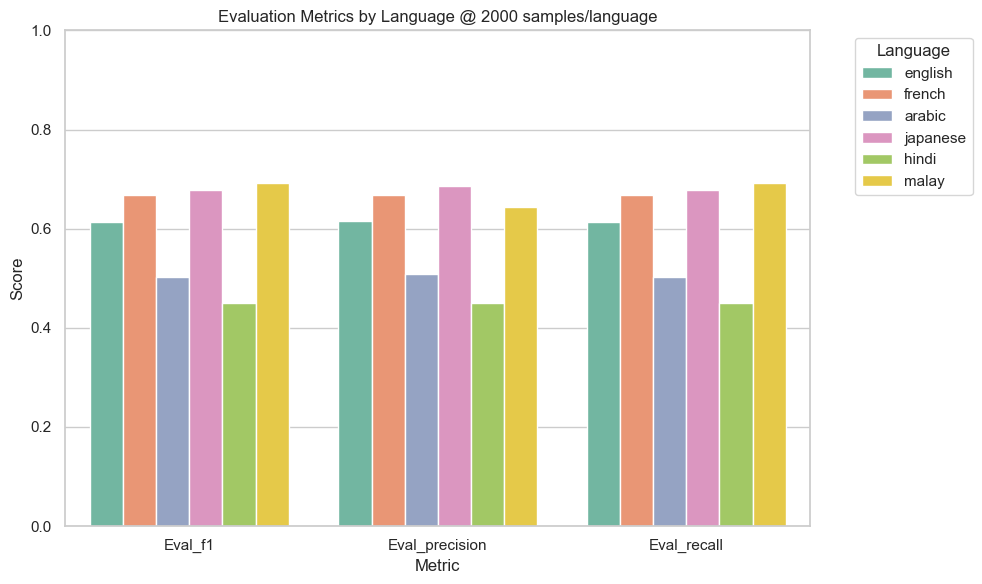

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Choose size (you can change to 1000, 1500, etc.)
final_size = 2000

# Extract metrics for the selected training size
metrics_list = ['eval_f1', 'eval_precision', 'eval_recall']
plot_data = []

for lang in langs:
    lang_metrics = results_by_size[final_size][lang]
    for metric in metrics_list:
        plot_data.append({
            'Language': lang,
            'Metric': metric.capitalize(),
            'Score': lang_metrics[metric]
        })

metrics_df = pd.DataFrame(plot_data)

# Plot grouped bar chart
plt.figure(figsize=(10, 6))
sns.barplot(
    data=metrics_df,
    x='Metric',
    y='Score',
    hue='Language',
    palette='Set2'
)

plt.title(f"Evaluation Metrics by Language @ {final_size} samples/language")
plt.ylim(0, 1)
plt.ylabel("Score")
plt.xlabel("Metric")
plt.legend(title="Language", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

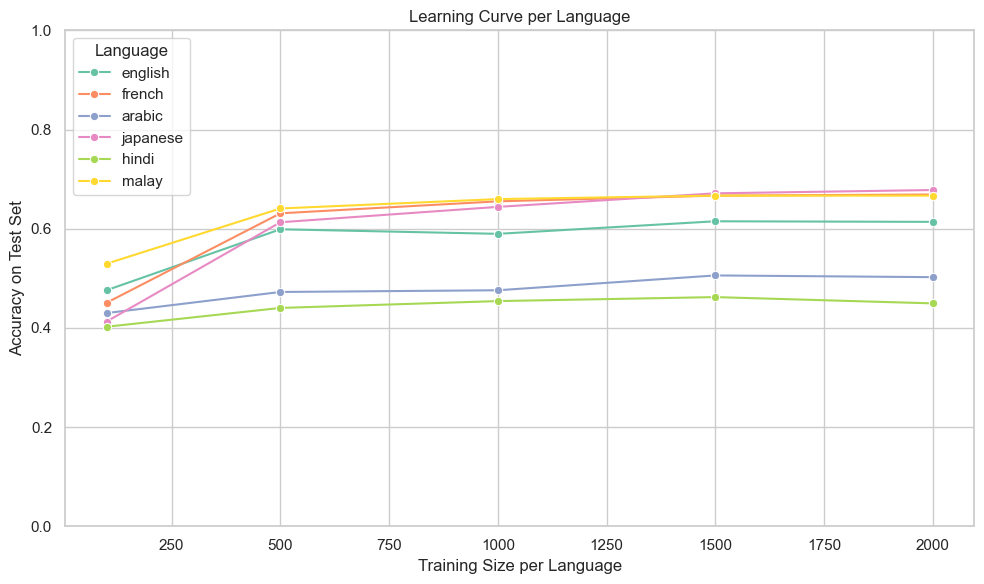

In [9]:
# Build DataFrame for learning curve
curve_data = []

for size, lang_dict in results_by_size.items():
    for lang, metrics in lang_dict.items():
        curve_data.append({
            'Training Size': size,
            'Language': lang,
            'Accuracy': metrics['eval_accuracy']
        })

curve_df = pd.DataFrame(curve_data)

# Plot line plot
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=curve_df,
    x='Training Size',
    y='Accuracy',
    hue='Language',
    marker='o',
    palette='Set2'
)

plt.title("Learning Curve per Language")
plt.ylabel("Accuracy on Test Set")
plt.xlabel("Training Size per Language")
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()

### 📈 Multilingual Fine-Tuning Performance: Key Observations

After training `distilbert-base-multilingual-cased` on 2000 **stratified sentiment examples** per language, we evaluate the model across all 6 languages.

#### 🧪 1. Accuracy Differs Significantly Across Languages

From the metric bar chart:

- **Malay, French, Japanese** consistently achieve high performance across **F1, Precision, and Recall** (≈ 0.68–0.70),
- **English** performs slightly below, stable across metrics (≈ 0.61),
- **Arabic and Hindi** lag behind (≈ 0.45–0.50), showing a clear **performance gap of ~20 points** compared to the top languages.

This suggests that even with equal data:
- The model **generalizes unevenly** across languages,
- Some languages may benefit more from **pretraining alignment**, script similarity, or **tokenization efficiency**.

#### 📉 2. Learning Curves Are Flatter for Arabic and Hindi

From the learning curve:

- Languages like **Malay, French, Japanese** show steep gains between 100 → 500 samples, then slower improvement,
- In contrast, **Arabic and Hindi** exhibit **flat or modest gains** across all training sizes,
- Most notably, they **do not benefit strongly from the first 500 samples**, suggesting a **harder learning curve** or **less efficient encoding**.

This may be due to:
- Differences in **morphology**, **tokenization fragmentation**, or **low-resource alignment** during pretraining,
- Structural or syntactic differences that **confuse the shared encoder**.

#### 🎯 Implications

- Equal data ≠ equal outcomes: **multilingual fine-tuning is not fair by default**.
- It's critical to:
  - **Monitor language-specific metrics**,
  - Consider **adaptive learning** or **language-specific adapters**,
  - Potentially **augment or reweight** low-performing languages during training.

These results demonstrate the **need for multilingual fairness and diagnostic evaluation** beyond overall accuracy.

In [12]:
transfer_results = {}

for train_lang in langs:
    print(f"\n🚀 Training ONLY on {train_lang.upper()} (2000 samples)")
    
    # Select stratified 2000-sample training set
    train_df = stratified_datasets[2000][stratified_datasets[2000]["language"] == train_lang]
    train_dataset = prepare_dataset(train_df)
    
    # Load fresh model
    model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

    training_args = TrainingArguments(
        output_dir=f"./results_transfer_{train_lang}",
        eval_strategy="no",
        per_device_train_batch_size=32,
        num_train_epochs=5,
        logging_steps=200,
        save_strategy="no",
        learning_rate=2e-5,
        weight_decay=0.01,
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    trainer.train()

    # Evaluate on all test languages
    transfer_results[train_lang] = {}
    for test_lang in langs:
        metrics = trainer.evaluate(eval_dataset=test_sets[test_lang])
        transfer_results[train_lang][test_lang] = metrics
        print(f"🧪 Test on {test_lang}: F1={metrics['eval_f1']:.3f} | Prec={metrics['eval_precision']:.3f} | Rec={metrics['eval_recall']:.3f}")


🚀 Training ONLY on ENGLISH (2000 samples)


Map:   0%|          | 0/1998 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_61664/2235659369.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
200,0.874000


🧪 Test on english: F1=0.625 | Prec=0.628 | Rec=0.625


/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


🧪 Test on french: F1=0.489 | Prec=0.550 | Rec=0.489


/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


🧪 Test on arabic: F1=0.385 | Prec=0.502 | Rec=0.385


/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


🧪 Test on japanese: F1=0.433 | Prec=0.453 | Rec=0.433


/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


🧪 Test on hindi: F1=0.420 | Prec=0.484 | Rec=0.420


/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


🧪 Test on malay: F1=0.477 | Prec=0.512 | Rec=0.477

🚀 Training ONLY on FRENCH (2000 samples)


Map:   0%|          | 0/1998 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_61664/2235659369.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
200,0.841800


🧪 Test on english: F1=0.522 | Prec=0.540 | Rec=0.522


/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


🧪 Test on french: F1=0.662 | Prec=0.659 | Rec=0.662


/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


🧪 Test on arabic: F1=0.421 | Prec=0.430 | Rec=0.421


/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


🧪 Test on japanese: F1=0.407 | Prec=0.442 | Rec=0.407


/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


🧪 Test on hindi: F1=0.384 | Prec=0.426 | Rec=0.384


/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


🧪 Test on malay: F1=0.567 | Prec=0.573 | Rec=0.567

🚀 Training ONLY on ARABIC (2000 samples)


Map:   0%|          | 0/1998 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_61664/2235659369.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
200,0.935700


🧪 Test on english: F1=0.387 | Prec=0.454 | Rec=0.387


/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


🧪 Test on french: F1=0.423 | Prec=0.514 | Rec=0.423


/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


🧪 Test on arabic: F1=0.430 | Prec=0.430 | Rec=0.430


/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


🧪 Test on japanese: F1=0.341 | Prec=0.352 | Rec=0.341


/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


🧪 Test on hindi: F1=0.394 | Prec=0.412 | Rec=0.394


/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


🧪 Test on malay: F1=0.463 | Prec=0.388 | Rec=0.463

🚀 Training ONLY on JAPANESE (2000 samples)


Map:   0%|          | 0/1998 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_61664/2235659369.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
200,0.826700


🧪 Test on english: F1=0.378 | Prec=0.394 | Rec=0.378


/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


🧪 Test on french: F1=0.383 | Prec=0.326 | Rec=0.383


/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


🧪 Test on arabic: F1=0.345 | Prec=0.366 | Rec=0.345


/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


🧪 Test on japanese: F1=0.684 | Prec=0.689 | Rec=0.684


/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


🧪 Test on hindi: F1=0.311 | Prec=0.385 | Rec=0.311


/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


🧪 Test on malay: F1=0.292 | Prec=0.438 | Rec=0.292

🚀 Training ONLY on HINDI (2000 samples)


Map:   0%|          | 0/1998 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_61664/2235659369.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
200,1.078700


🧪 Test on english: F1=0.387 | Prec=0.500 | Rec=0.387


/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


🧪 Test on french: F1=0.425 | Prec=0.371 | Rec=0.425


/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


🧪 Test on arabic: F1=0.420 | Prec=0.575 | Rec=0.420


/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


🧪 Test on japanese: F1=0.322 | Prec=0.445 | Rec=0.322


/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


🧪 Test on hindi: F1=0.401 | Prec=0.403 | Rec=0.401


/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


🧪 Test on malay: F1=0.383 | Prec=0.341 | Rec=0.383

🚀 Training ONLY on MALAY (2000 samples)


Map:   0%|          | 0/1998 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_61664/2235659369.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
200,0.716900


🧪 Test on english: F1=0.408 | Prec=0.466 | Rec=0.408


/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


🧪 Test on french: F1=0.392 | Prec=0.506 | Rec=0.392


/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


🧪 Test on arabic: F1=0.375 | Prec=0.400 | Rec=0.375


/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


🧪 Test on japanese: F1=0.389 | Prec=0.408 | Rec=0.389


/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


🧪 Test on hindi: F1=0.375 | Prec=0.459 | Rec=0.375


/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


🧪 Test on malay: F1=0.687 | Prec=0.635 | Rec=0.687


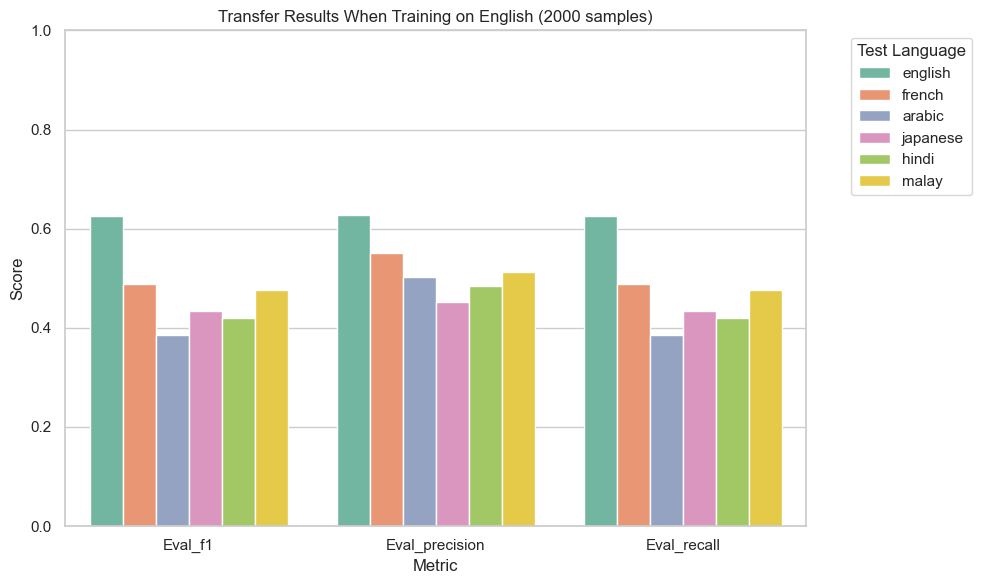

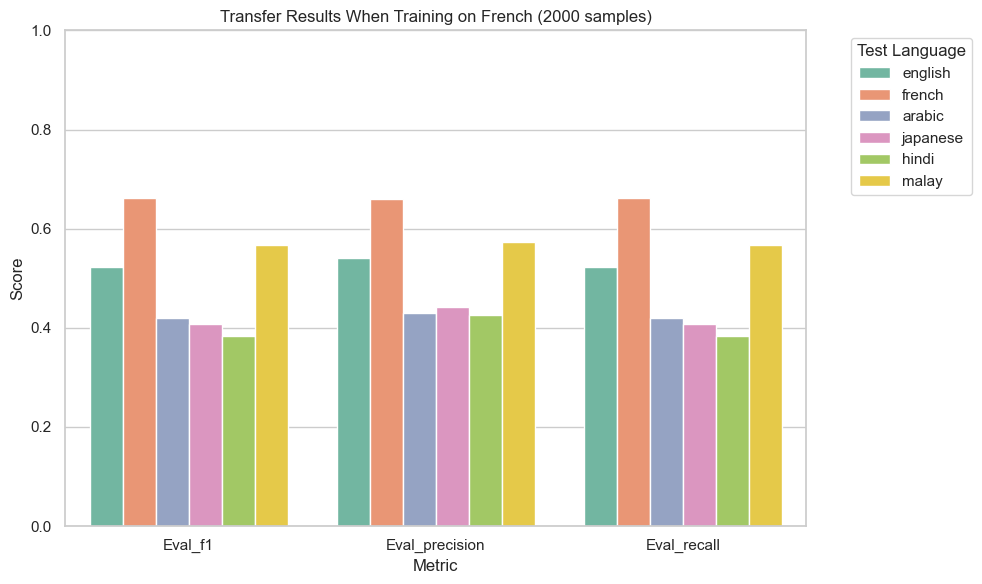

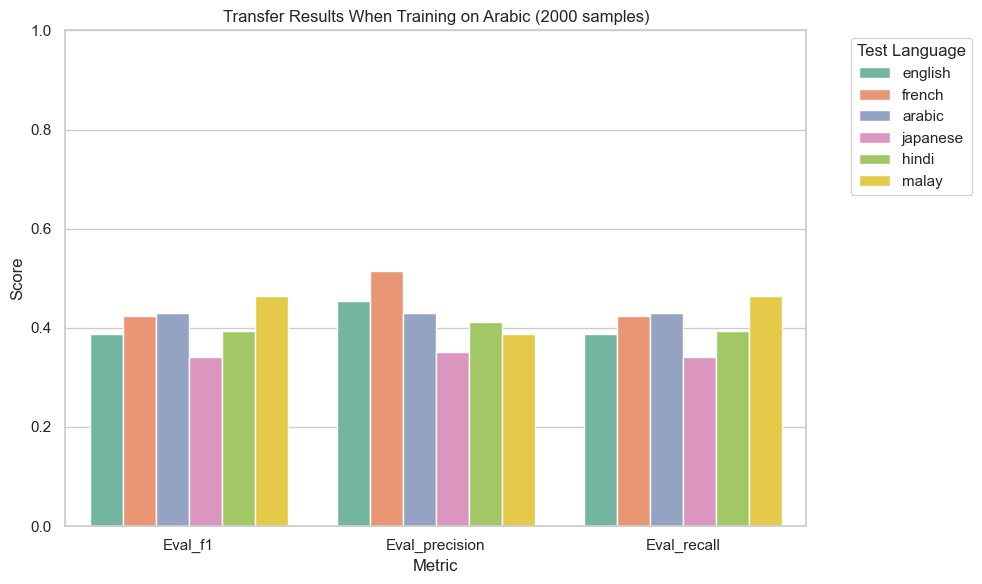

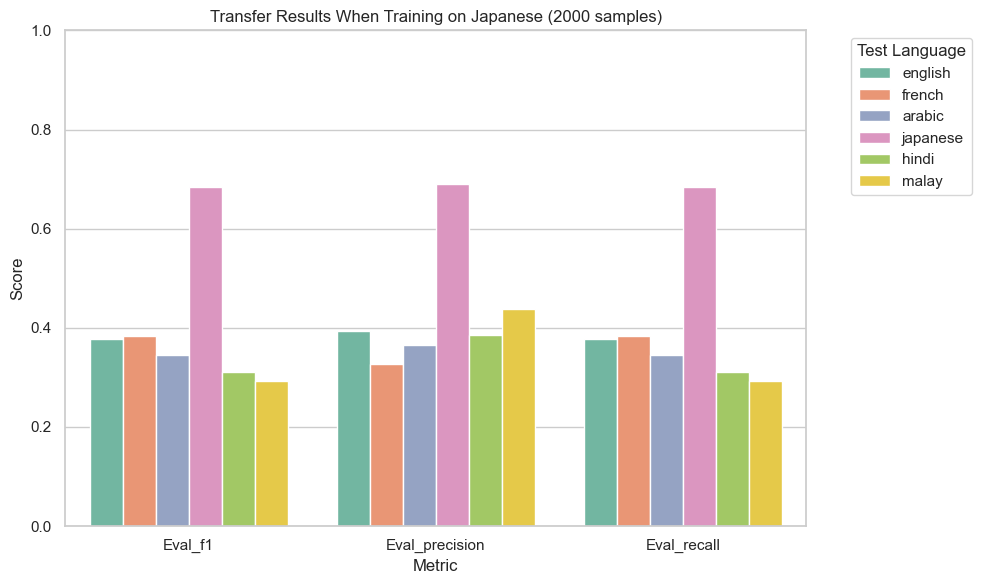

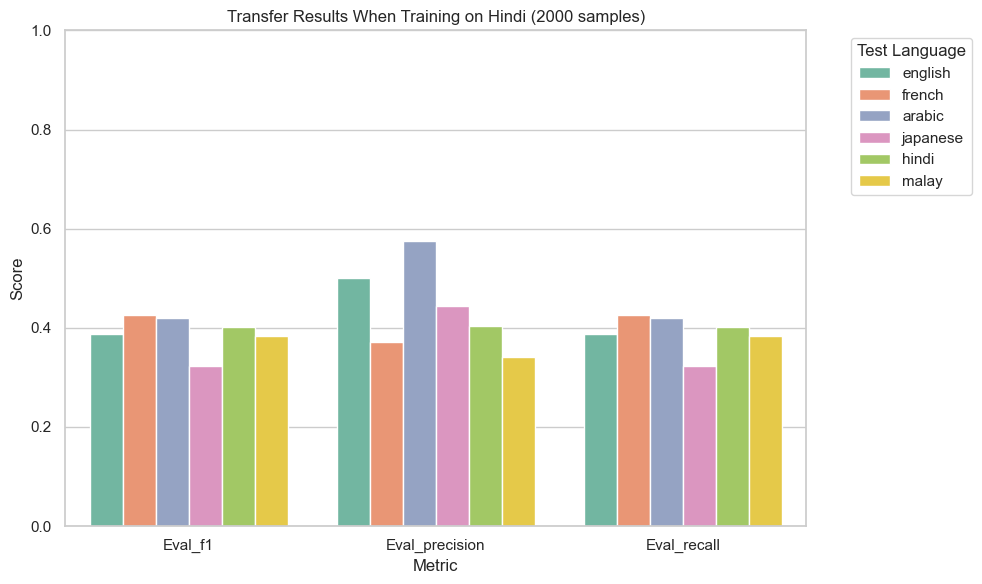

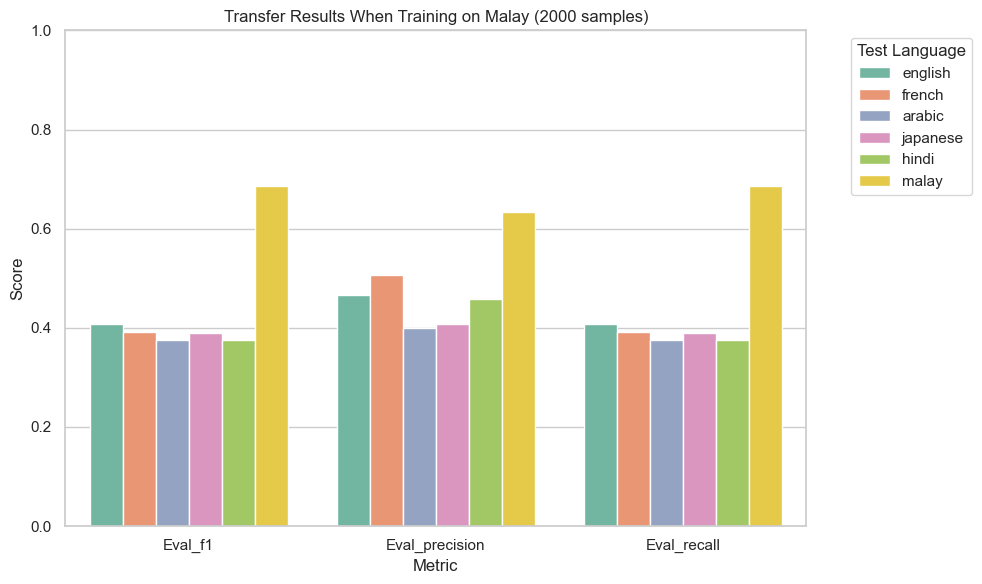

In [13]:
# Plot transfer performance grouped by metric for each training language

for train_lang in langs:
    plot_data = []
    for test_lang, metrics in transfer_results[train_lang].items():
        for metric in ["eval_f1", "eval_precision", "eval_recall"]:
            plot_data.append({
                "Test Language": test_lang,
                "Metric": metric.capitalize(),
                "Score": metrics[metric]
            })

    df_plot = pd.DataFrame(plot_data)

    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=df_plot,
        x="Metric",
        y="Score",
        hue="Test Language",
        palette="Set2"
    )
    plt.title(f"Transfer Results When Training on {train_lang.capitalize()} (2000 samples)")
    plt.ylim(0, 1)
    plt.ylabel("Score")
    plt.xlabel("Metric")
    plt.legend(title="Test Language", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

### 🌐 Cross-Language Transfer vs. Joint Multilingual Training

Now that we have both:
- 📊 **Joint training** on all 6 languages (2000 examples each),
- 🔁 **Transfer evaluation**, where the model is trained on one language and tested on all others,

we can analyze how multilingual models generalize under each strategy.

#### 🧠 1. Multilingual Training Outperforms One-Language Transfer

From our earlier evaluation:
- Joint training yields **F1 ≈ 0.61–0.69** for most languages,
- In contrast, one-language models rarely exceed **F1 ≈ 0.52** on other languages.

This confirms that:
- 🔁 **Cross-lingual transfer alone is limited** — especially for distant scripts or grammar (e.g., Arabic → Japanese),
- 🌍 **Multilingual supervision improves generalization** across all test languages.

#### 📉 2. Transfer Models Only Excel in Their Own Language

Each monolingual model achieves **highest F1 when tested on its own language**:
- English-trained model → English test: 0.625
- French-trained → French test: 0.662
- Japanese-trained → Japanese test: 0.684
- Malay-trained → Malay test: 0.687

This shows:
- Monolingual training leads to **language-specific specialization**,
- But offers **limited generalization** to others.

#### 🔍 3. Arabic and Hindi Transfer Poorly — Both In and Out

- Models trained on **Arabic or Hindi** score **low both in-domain and out-of-domain** (F1 ≈ 0.39–0.43 max),
- Even when evaluated on each other (e.g., Hindi-trained → Arabic), performance remains low.

This aligns with our earlier observation:
- 📉 Arabic and Hindi show **flatter learning curves** and **weaker multilingual performance**,
- Possibly due to **vocabulary fragmentation**, **script/token mismatch**, or lower **pretraining exposure**.

### 🧬 Conclusion

| Strategy                | Strengths                          | Limitations                         |
|------------------------|------------------------------------|-------------------------------------|
| **Multilingual Training** | Best all-round performance           | Requires equal and sufficient data  |
| **Monolingual Transfer**  | Strong in-language performance       | Poor cross-language generalization  |

To build robust multilingual systems, **joint multilingual training is essential**. Transfer learning alone is **not enough**, especially for **divergent or low-resource languages**.

Next steps may include:
- Adding **language adapters or embeddings**,
- Exploring **data augmentation** or **translation-based balancing**,
- Using **alignment-aware losses** for cross-lingual supervision.